### Import Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
import seaborn as sns

### Dataset Path Declaration

In [2]:
dataset_path=r"D:\Personal\Capstone\Datasets\CNRPark\A"
class_path=[os.path.join(dataset_path, folder) for folder in os.listdir(dataset_path)]

### Image Preprocessing

In [3]:
images=[]
labels=[]
class_mapper={
    "free":0,
    "busy":1
}
image_size=(120,120)
for cls in class_path:
    print(f"Started: {os.path.basename(cls)}")
    for file in os.listdir(cls)[:2500]:
        image_path=os.path.join(cls,file)
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,image_size)
        image=image/255.0
        images.append(image)
        labels.append(class_mapper[os.path.basename(cls)])
    print("Finished")

images=np.array(images)
labels=np.array(labels)

Started: busy
Finished
Started: free
Finished


Number of classes:  2
Number of images in busy class:3621
Number of images in free class:2550


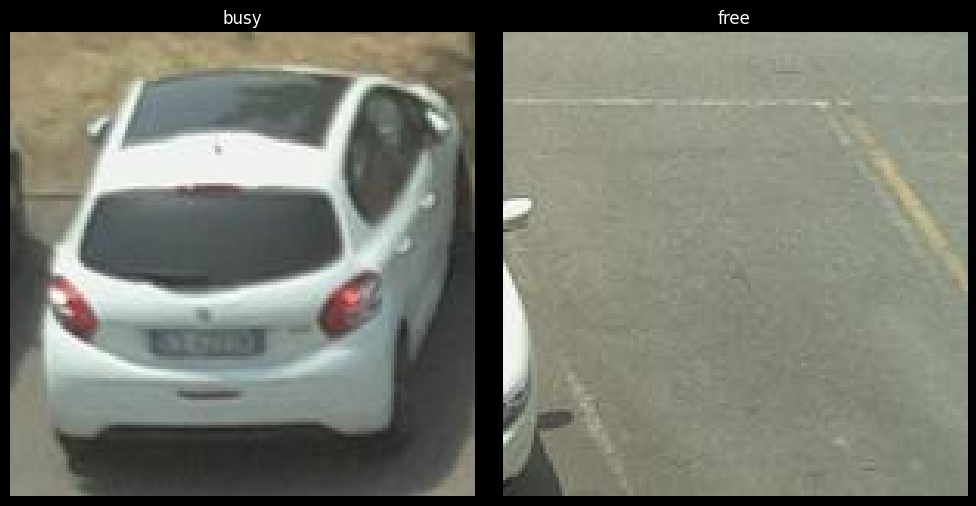

In [4]:
print("Number of classes: ", len(os.listdir(dataset_path)))
for cls in class_path:
    print(f"Number of images in {os.path.basename(cls)} class:"+str(len((os.listdir(cls)))))

fig,axis=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axis=axis.flatten()
for cls,ax in zip(class_path,axis):
    random_image_path=os.path.join(cls,np.random.choice(os.listdir(cls)))
    random_image=plt.imread(random_image_path)
    ax.imshow(random_image)
    ax.axis('off')
    ax.set_title(os.path.basename(cls))
plt.tight_layout()
plt.show()

### Train Test Split

In [5]:
x_train, x_test, y_train, y_test=train_test_split(images,labels,test_size=0.2,random_state=100)

### Creating a sequential CNN model

In [6]:
def cnn_model(image_size):
    model=Sequential()
    #Input Layer
    model.add(Input(shape=(image_size),name='input_layer'))

    #Block 1:
    model.add(Conv2D(filters=16,kernel_size=(5,5),activation='relu',name='conv_layer_1'))
    model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',name='conv_layer_1_1'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='maxpooling_layer_1'))
    model.add(Dropout(0.25,name="dropout_layer_1"))

    #Block 2:
    model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',name='conv_layer_2'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='maxpooling_layer_2'))
    model.add(Dropout(0.25,name="dropout_layer_2"))

    #Block 3:
    model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',name='conv_layer_3'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='maxpooling_layer_3'))
    model.add(Dropout(0.25,name="dropout_layer_3"))

    #Flatten
    model.add(Flatten(name='flatten'))

    #Dense Layer
    model.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001),name='dense_1'))
    model.add(Dense(32,activation='relu',name='dense_2'))
    model.add(Dense(1,activation='sigmoid',name='dense_3'))
    return model

In [7]:
model=cnn_model((120,120,3))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer_1 (Conv2D)       (None, 116, 116, 16)      1216      
                                                                 
 conv_layer_1_1 (Conv2D)     (None, 114, 114, 16)      2320      
                                                                 
 maxpooling_layer_1 (MaxPoo  (None, 57, 57, 16)        0         
 ling2D)                                                         
                                                                 
 dropout_layer_1 (Dropout)   (None, 57, 57, 16)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 55, 55, 32)        4640      
                                                                 
 maxpooling_layer_2 (MaxPoo  (None, 27, 27, 32)        0         
 ling2D)                                             

### Training Images

In [8]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history=model.fit(x_train,y_train,
                  callbacks=[early_stopping],
                  epochs=10,
                  batch_size=32, 
                  validation_split=0.2)

Epoch 1/10


100/100 [==============================] - 11s 97ms/step - loss: 0.4246 - accuracy: 0.8284 - val_loss: 0.1626 - val_accuracy: 0.9775
Epoch 2/10
100/100 [==============================] - 9s 87ms/step - loss: 0.0786 - accuracy: 0.9884 - val_loss: 0.1104 - val_accuracy: 0.9875
Epoch 3/10
100/100 [==============================] - 9s 88ms/step - loss: 0.0584 - accuracy: 0.9928 - val_loss: 0.0873 - val_accuracy: 0.9787
Epoch 4/10
100/100 [==============================] - 9s 86ms/step - loss: 0.0467 - accuracy: 0.9947 - val_loss: 0.1083 - val_accuracy: 0.9613
Epoch 5/10
100/100 [==============================] - 9s 87ms/step - loss: 0.0438 - accuracy: 0.9937 - val_loss: 0.0442 - val_accuracy: 0.9937
Epoch 6/10
100/100 [==============================] - 9s 86ms/step - loss: 0.0232 - accuracy: 0.9994 - val_loss: 0.0331 - val_accuracy: 0.9950
Epoch 7/10
100/100 [==============================] - 9s 91ms/step - loss: 0.0279 - accuracy: 0.9981 - val_loss: 0.0415 - val_accuracy: 0.9

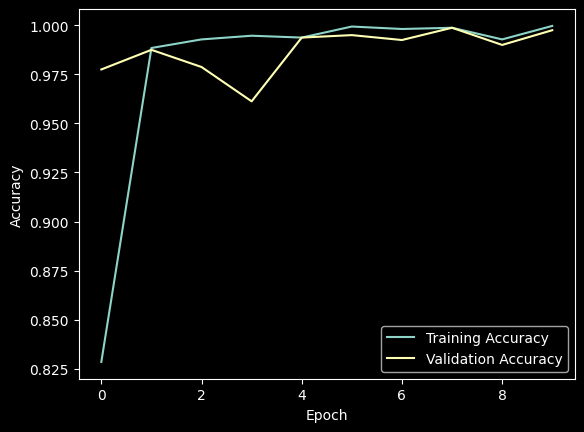

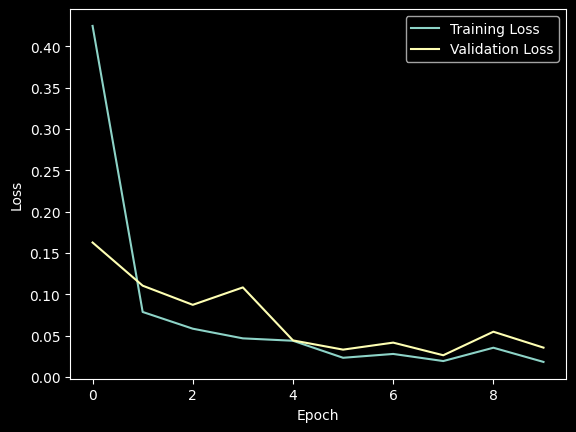

In [9]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing and validation

In [10]:
prediction=model.predict(x_test)
predicted_classes = (prediction > 0.5).astype("int32")

32/32 [==============================] - 1s 25ms/step


In [11]:
accuracy=accuracy_score(y_test,predicted_classes)
precision=precision_score(y_test,predicted_classes)
f1_score=f1_score(y_test,predicted_classes)
print(f"Accuracy:{accuracy}\nPrecision:{precision}\nF1 Score:{f1_score}")

Accuracy:1.0
Precision:1.0
F1 Score:1.0


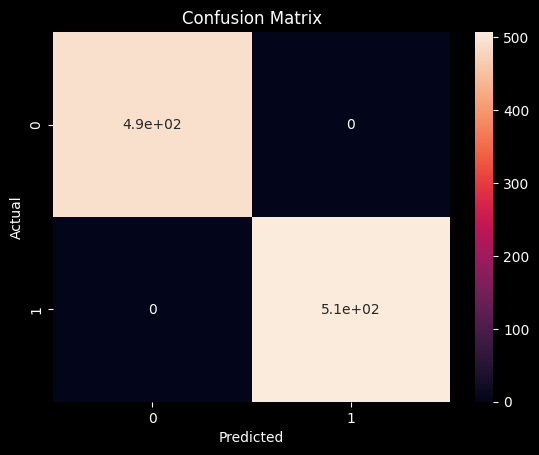

In [12]:
cm=confusion_matrix(y_test,predicted_classes)
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from keras.preprocessing.image import ImageDataGenerator
testing_directory=r"D:\Personal\Capstone\Datasets\PKLot\Dataset\Model\Cloudy\val"
datagen=ImageDataGenerator(rescale=1./255)
val_datagen=datagen.flow_from_directory(directory=testing_directory,target_size=(120,120),color_mode='rgb',class_mode='binary',shuffle=False)
val_datagen.class_indices
predictions=model.predict(val_datagen)
predicted_classes=(predictions>0.5).astype("uint32")
accuracy=accuracy_score(val_datagen.classes,predicted_classes)
accuracy

Found 35094 images belonging to 2 classes.
1097/1097 [==============================] - 33s 30ms/step


0.9367128284037157

In [14]:
from keras.models import save_model
model.save(r'D:\Personal\Capstone\custom_cnn\cnn_model_3.keras')